<a id='top'></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Predicting Nightly Mood Scores from Previously Submitted Mood, Sleep, and Daily Activity
Adding the final piece to the puzzle: self-reported sleep 

Some good information can be found [here](https://towardsdatascience.com/comprehensive-guide-to-multiclass-classification-with-sklearn-127cc500f362) on the general process.

In [2]:
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2
from src.analysis import mood_prediction

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
from scipy import stats

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib.dates as mdates

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import DBSCAN

<a id='toc'></a>

# Table of Contents
1. [Data Import](#data_import)
2. [Inspection](#inspection)
3. [Clustering Analysis](#clustering_analysis)
4. [Feature Importance](#feature_importance)
3. [Modeling](#modeling)
4. [Evaluation](#evaluation)
5. [Saving](#saving)

---

<a id='data_import'></a>

# Data Import
We use the `ImportProcessing` to get the relevant data.

In [4]:
data = mood_prediction.ImportProcessing(data_dir="../data/")

In [5]:
data.mood_and_activity = data.remove_participant(data.mood_and_activity,"oxcpr7e3")

---

<a id='inspection'></a>

# Inspection
Doing some higher-level inspection of the data.

## Score Distribution
To aid in binarizing the data more appropriately.

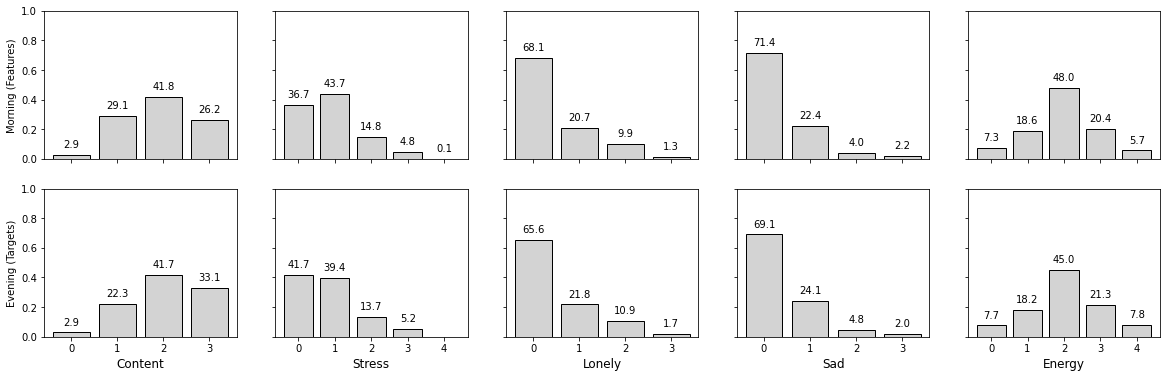

In [6]:
inspection = mood_prediction.Inspection()
_  = inspection.get_mood_distribution(data.mood_and_activity,plot=True)

## Difference in Scores (Evening - Morning)
The simplest way to understand the difference in mood scores is to simply subtract them from one another. The more identical the scores, the greater the instance of zero.

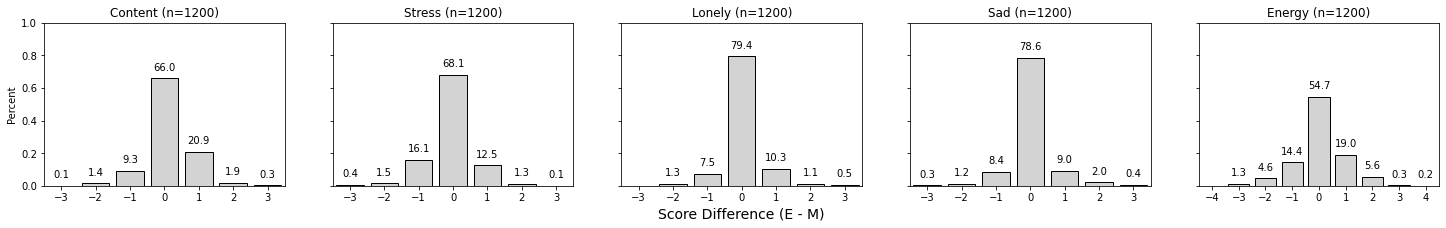

In [7]:
_ = inspection.get_mood_difference(data.mood_and_activity,plot=True)

<div class="alert alert-block alert-info">
    
As expected, many of the differences between the mood scores are zero. This finding is less apparent when considering `energy` which makes sense since the energy of the participants should change. However, I would expect this change to be skewed towards a positive difference (indicating participants were _more_ tired in the evening) but that is not the case. Although they could have low energy in the mornings when they initially wake up. 
    
</div>

<div class="alert alert-block alert-info">
    
The maximum percentages also highlight a sort of upper bound on the accuracy of the model. Just like with our previous analysis, the model might be biased to simply report the same mood score since that is the most influential factor it seems.
    
</div>

[Back to Inspection](#inspection)

---

<a id='clustering_analysis'></a>

[Back to ToC](#toc)
# Sleep Clustering Analysis
Since we cannot do a similar analysis to what we have done in the past with IEQ and activity data, we can try some newer, more advanced techniques.

Consider this [article](https://towardsdatascience.com/cluster-analysis-create-visualize-and-interpret-customer-segments-474e55d00ebb) for a more robust way to cluster and analyze. 

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [9]:
def scale(df_in,scale_type="standard"):
    """
    Scales each row of the dataframe
    """
    df = df_in.copy()
    try:
        df.drop(["beiwe","date"],axis="columns",inplace=True)
    except KeyError:
        # colums not in dataframe
        pass
    df.dropna(inplace=True)
    if scale_type == "standard":
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()
    scaler.fit(df)
    return scaler.transform(df)

In [10]:
def elbow(df_in):
    """
    Plots the inertia vs number of cluster for the elbow method
    """
    scores = [KMeans(n_clusters=i+2).fit(df_in).inertia_ 
              for i in range(10)]
    fig, ax = plt.subplots(figsize=(4,4))
    ax.plot(np.arange(2,12),scores)
    plt.xlabel('Number of Clusters')
    plt.ylabel("Inertia")
    
    plt.show()
    plt.close()

In [11]:
def run_kmeans(df_in,k,scale_type="standard"):
    """
    Runs k-means clustering
    """
    df = df_in.copy()
    df.dropna(inplace=True)
    df_scaled = scale(df,scale_type=scale_type)
    clustering = KMeans(n_clusters=k).fit(df_scaled)
    df["label"] = clustering.labels_
    sc = silhouette_score(df, clustering.labels_,metric="euclidean")
    return df, sc

In [12]:
def run_dbscan(df_in,scale_type="standard",eps=0.5,min_samples=3):
    """
    Runs DBSCAN
    """
    df = df_in.copy()
    df.dropna(inplace=True)
    df_scaled = scale(df,scale_type=scale_type)
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(df_scaled)
    df["label"] = clustering.labels_
    sc = silhouette_score(df, clustering.labels_,metric="cosine")
    return df, sc

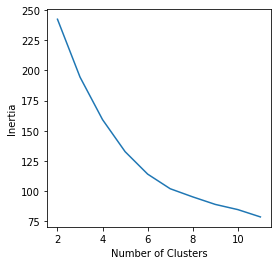

In [13]:
mood = "discontent"
data_to_use = data.mood_only[["tst","naw","sol","restful",f"{mood}_e"]]
data_scaled = scale(data_to_use,"minmax")
elbow(data_scaled)

In [14]:
res, sc = run_dbscan(data_to_use,scale_type="minmax",eps=0.25,min_samples=5)
sc

-0.18233536498478

In [15]:
res, sc = run_kmeans(data_to_use,k=5,scale_type="minmax")
sc

-0.09508113174428284

<div class="alert alert-block alert-danger">
    
This analysis does not seem to work well - we should consider other approaches.
    
</div>

[Back to Clustering Analysis](#clustering_analysis)

---

<a id='feature_importance'></a>

[Back to ToC](#toc)
# Feature Importance from Random Forest
Rather than consider the kNN approach, we can use a random forest trained on all the data to understand which features are most important for analysis.

In [16]:
modeling = mood_prediction.Model()

## Adding Features
We add the `step_goal` feature which determine whether or not the participant was able to reach the 10K (default) step goal.

In [26]:
data.mood_and_activity = modeling.binarize_steps(data.mood_and_activity)
data.mood_and_activity.head()

,beiwe,content_e,stress_e,lonely_e,sad_e,energy_e,redcap,date,content_m,stress_m,lonely_m,sad_m,energy_m,tst,sol,naw,restful,steps,distance,discontent_m,discontent_e,step_goal
2,rvhdl2la,2.0,1.0,0.0,0.0,1.0,29,2020-05-13,1.0,1.0,2.0,3.0,0.0,5.3,5.0,2.0,2.0,4722.0,1.853799,2.0,1.0,0
4,xdbdrk6e,2.0,1.0,2.0,1.0,3.0,23,2020-05-13,2.0,1.0,2.0,1.0,2.0,8.0,20.0,3.0,2.0,4199.0,1.720204,1.0,1.0,0
6,qh34m4r9,3.0,1.0,0.0,0.0,4.0,68,2020-05-13,3.0,0.0,0.0,0.0,1.0,8.0,20.0,2.0,3.0,11632.0,5.302906,0.0,0.0,1
8,tmexej5v,2.0,1.0,1.0,0.0,3.0,42,2020-05-13,2.0,1.0,1.0,0.0,3.0,6.0,15.0,0.0,2.0,521.0,0.202008,1.0,1.0,0
9,vpy1a985,2.0,1.0,2.0,1.0,2.0,50,2020-05-13,2.0,1.0,2.0,1.0,2.0,7.0,10.0,1.0,2.0,553.0,0.237737,1.0,1.0,0


## BIinarizing Datasets

In [19]:
data_bi = modeling.binarize_mood(data.mood_and_activity)
data_bi_targets = modeling.binarize_mood(data.mood_and_activity,binarize_features=False)

## Getting Feature Importance

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_validate

### GridSearch to Optimize Parameters

In [21]:
def optimize_rfc(df_in,params,features=["tst","sol","restful","naw"],target_list=["discontent","sad","lonely","stress"]):
    """
    optimizes the paramters for the random forest classifier
    """
    df = df_in.copy()
    opt_RFC = GridSearchCV(RandomForestClassifier(),params,cv=5)
    for target in target_list:
        target = [f"{target}_e"]
        data_to_use = df[features + target].dropna()
        X = data_to_use[features]
        y = data_to_use[target]
        opt_RFC.fit(X,y)
        print(f"{target}:")
        for p, val in opt_RFC.best_params_.items():
            print(f"\t{p}:\t{val}")

In [22]:
params={"n_estimators":[2,5,10,20,100],"max_depth":[2,5,10],"min_samples_split":[2,3,4,5]}
optimize_rfc(data_bi,params)

['discontent_e']:
	max_depth:	5
	min_samples_split:	2
	n_estimators:	20
['sad_e']:
	max_depth:	2
	min_samples_split:	2
	n_estimators:	2
['lonely_e']:
	max_depth:	5
	min_samples_split:	2
	n_estimators:	20
['stress_e']:
	max_depth:	10
	min_samples_split:	4
	n_estimators:	100


<div class="alert alert-block alert-info">
    
We will use the following parameters:
* `n_estimators`: 10
* `max_depth`: 5
* `min_samples_split`: 4
    
</div>

### Finding Importances

In [43]:
def get_feature_importances(df_in,params,features=["tst","sol","restful","naw"],target_list=["discontent","sad","lonely","stress","energy"],save=False,verbose=False):
    """
    determines which of the features are most important for the random forest classifier
    """
    df = df_in.copy()
    res = {feature: [] for feature in features}
    res["mood"] = []
    fig, axes = plt.subplots(len(target_list),1,figsize=(4,2*len(target_list)),sharex=True)
    for target, ax in zip(target_list,axes):
        targets = [f"{target}_e"]
        data_to_use = df[features + targets].dropna()
        X = data_to_use[features]
        y = data_to_use[targets]
        clf = RandomForestClassifier(**params)
        output = cross_validate(clf, X, y, cv=5, scoring='accuracy', return_estimator=True)
        li =[]
        for idx,estimator in enumerate(output['estimator']):
            if verbose:
                print("Features sorted by their score for estimator {}:".format(idx))
                feature_importances = pd.DataFrame(estimator.feature_importances_,
                                                   index = X.columns,
                                                    columns=['importance']).sort_values('importance', ascending=False)
                print(feature_importances)
            li.append(estimator.feature_importances_)
            
        res["mood"].append(target)
        for key, value in zip(features,pd.DataFrame(li).mean()):
            res[key].append(value)
        
        ax.stem(X.columns,estimator.feature_importances_,
               linefmt="k-",markerfmt="ko",basefmt="white")
        ax.set_ylim([0,0.42])
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
            
        ax.tick_params(labelsize=13)
        ax.set_title(" " + target.title(),fontsize=13,pad=0,loc="left",ha="left")
        
    ax.set_xticklabels(["TST","SOL","Restful","NAW"])
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.xlabel("Sleep Feature",fontsize=16)
    plt.ylabel("Mean Decrease in Impurity",fontsize=16)
    if save:
        plt.savefig("../reports/figures/ema_summary/feature_importance-sleep_on_mood-bar.pdf",bbox_inches="tight")
    plt.show()
    plt.close()
            
    return pd.DataFrame(res)

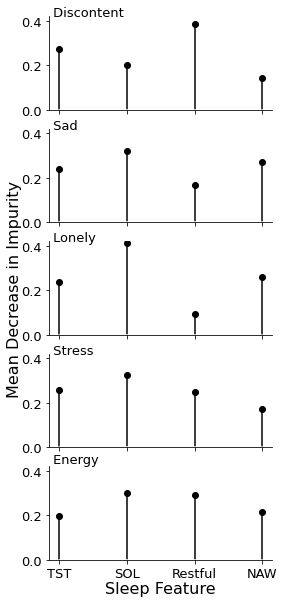

In [45]:
opt_params = {"n_estimators":10,"max_depth":5,"min_samples_split":4}
sleep_importance = get_feature_importances(data_bi,opt_params,save=True)

In [46]:
sleep_importance

,tst,sol,restful,naw,mood
0,0.250314,0.189844,0.415144,0.144698,discontent
1,0.262487,0.311690,0.217681,0.208142,sad
2,0.251140,0.352746,0.155189,0.240925,lonely
3,0.269321,0.259454,0.252560,0.218665,stress
4,0.211759,0.297003,0.312019,0.179219,energy


[Back to Feautre Importance](#feature_importance)

---

<a id='modeling'></a>

[Back to Top](#top)